In [1]:
# 1
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
import numpy as np

# from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

matplotlib.style.use("ggplot")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
# 2
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

In [3]:
# 3
train_dataset = datasets.ImageFolder(
    root="data/archive/train", transform=train_transform
)
val_dataset = datasets.ImageFolder(
    root="data/archive/test", transform=val_transform
)
train_dataloder = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloder = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [4]:
# 4
def resnet50(pretrained=True, requires_grad=False):
    model = models.resnet50(progress=True, pretrained=pretrained)
    if not requires_grad:
        for param in model.parameters():
            param.requires_grad = False
    elif requires_grad:
        for param in model.parameters():
            param.requires_grad = True
    model.fc = nn.Linear(2048, 2)
    return model

In [5]:
# 5 learning rate scheduler
class LRScheduler:
    def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode="min",
            patience=self.patience,
            min_lr=self.min_lr,
            factor=self.factor,
            verbose=True,
        )

    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [6]:
# 6 early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path="data/checkpoint.pt"):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f}")
            print(f"--> {val_loss:.6f}).  Saving model ...")
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss

In [7]:
# 7 parser
# parser = argparse.ArgumentParser()
# parser.add_argument(
#     "--lr-scheduler", dest="lr_scheduler", action="store_true", default=False
# )
# parser.add_argument(
#     "--early-stopping", dest="early_stopping", action="store_true", default=False
# )
# args = vars(parser.parse_args())

In [8]:
# 8
print(f"Computation device: {device}\n")
model = models.resnet50(pretrained=True).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters\n")

Computation device: cuda:0



c:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


25,557,032 total parameters
25,557,032 training parameters



In [9]:
# 8.1 lr scheduler
lr = 0.001
epoch_num = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss_plot_name = 'loss'
acc_plot_name = 'accuracy'
model_name = 'resnet50'


lr_scheduler_bool = True
early_stopping_bool = False
if lr_scheduler_bool:
    print('info: init lr scheduler')
    lr_scheduler = LRScheduler(optimizer)
    loss_plot_name = 'loss_lr_scheduler'
    acc_plot_name = 'accuracy_lr_scheduler'
    model_name = 'resnet50_lr_scheduler'
if early_stopping_bool:
    print('info: init early stopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'loss_early_stopping'
    acc_plot_name = 'accuracy_early_stopping'
    model_name = 'resnet50_early_stopping'

info: init lr scheduler


In [10]:
# 9 training
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm_notebook(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))

    for i, data in prog_bar:
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / counter
    train_accuracy = 100.0 * train_running_correct / total
    return train_loss, train_accuracy

In [11]:
# 10 validate
def validate(model, test_dataloader, val_dataset, criterion):
    print('VALIDATION')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm_notebook(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))

    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()

        val_loss = val_running_loss / counter
        val_accuracy = 100.0 * val_running_correct / total
        return val_loss, val_accuracy

In [12]:
# 11 model training
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []


start = time.time()
for epoch in range(epoch_num):
    print(f"Epoch {epoch+1} of {epoch_num}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloder, train_dataset, optimizer, criterion)
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloder, val_dataset, criterion)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if lr_scheduler_bool:
        lr_scheduler(val_epoch_loss)
    if early_stopping_bool:
        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
    print(f'Time: {time.time()-start:.2f} sec')
    print('-'*50)


Epoch 1 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 2.3080, Train Acc: 58.23
Val Loss: 135.1947, Val Acc: 32.60
Time: 15.81 sec
--------------------------------------------------
Epoch 2 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.6363, Train Acc: 68.67
Val Loss: 2.9681, Val Acc: 55.80
Time: 27.35 sec
--------------------------------------------------
Epoch 3 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.4703, Train Acc: 78.71
Val Loss: 0.6103, Val Acc: 69.80
Time: 38.98 sec
--------------------------------------------------
Epoch 4 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3863, Train Acc: 81.93
Val Loss: 0.9039, Val Acc: 65.60
Time: 50.10 sec
--------------------------------------------------
Epoch 5 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3531, Train Acc: 85.54
Val Loss: 0.6388, Val Acc: 72.40
Time: 62.70 sec
--------------------------------------------------
Epoch 6 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.3238, Train Acc: 85.54
Val Loss: 1.2032, Val Acc: 67.80
Time: 74.37 sec
--------------------------------------------------
Epoch 7 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2599, Train Acc: 89.76
Val Loss: 0.6453, Val Acc: 75.80
Time: 86.23 sec
--------------------------------------------------
Epoch 8 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2466, Train Acc: 89.96
Val Loss: 0.9881, Val Acc: 69.60
Time: 97.96 sec
--------------------------------------------------
Epoch 9 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.
Train Loss: 0.1931, Train Acc: 92.57
Val Loss: 0.7908, Val Acc: 71.80
Time: 110.00 sec
--------------------------------------------------
Epoch 10 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1430, Train Acc: 95.58
Val Loss: 0.8057, Val Acc: 73.40
Time: 121.88 sec
--------------------------------------------------
Epoch 11 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0881, Train Acc: 95.78
Val Loss: 0.7112, Val Acc: 74.80
Time: 142.29 sec
--------------------------------------------------
Epoch 12 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0466, Train Acc: 98.39
Val Loss: 0.6605, Val Acc: 78.40
Time: 153.85 sec
--------------------------------------------------
Epoch 13 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0404, Train Acc: 98.80
Val Loss: 0.6431, Val Acc: 79.20
Time: 165.82 sec
--------------------------------------------------
Epoch 14 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0364, Train Acc: 99.20
Val Loss: 0.6136, Val Acc: 80.20
Time: 177.53 sec
--------------------------------------------------
Epoch 15 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 2.5000e-04.
Train Loss: 0.0423, Train Acc: 98.59
Val Loss: 0.7765, Val Acc: 76.80
Time: 189.69 sec
--------------------------------------------------
Epoch 16 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0223, Train Acc: 99.40
Val Loss: 0.8052, Val Acc: 76.60
Time: 203.04 sec
--------------------------------------------------
Epoch 17 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0458, Train Acc: 98.80
Val Loss: 0.7005, Val Acc: 78.20
Time: 215.93 sec
--------------------------------------------------
Epoch 18 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0296, Train Acc: 98.80
Val Loss: 0.8762, Val Acc: 77.00
Time: 227.81 sec
--------------------------------------------------
Epoch 19 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0175, Train Acc: 99.40
Val Loss: 0.6021, Val Acc: 83.00
Time: 239.97 sec
--------------------------------------------------
Epoch 20 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0238, Train Acc: 99.60
Val Loss: 0.6503, Val Acc: 81.00
Time: 251.78 sec
--------------------------------------------------
Epoch 21 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0346, Train Acc: 98.80
Val Loss: 0.8230, Val Acc: 79.00
Time: 263.85 sec
--------------------------------------------------
Epoch 22 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0254, Train Acc: 99.20
Val Loss: 0.8918, Val Acc: 76.80
Time: 275.71 sec
--------------------------------------------------
Epoch 23 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0224, Train Acc: 99.40
Val Loss: 0.7576, Val Acc: 80.80
Time: 287.69 sec
--------------------------------------------------
Epoch 24 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0190, Train Acc: 99.20
Val Loss: 0.5763, Val Acc: 81.60
Time: 303.88 sec
--------------------------------------------------
Epoch 25 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0439, Train Acc: 98.19
Val Loss: 0.7166, Val Acc: 78.20
Time: 315.73 sec
--------------------------------------------------
Epoch 26 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0211, Train Acc: 99.20
Val Loss: 0.7305, Val Acc: 78.80
Time: 327.84 sec
--------------------------------------------------
Epoch 27 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0177, Train Acc: 99.60
Val Loss: 0.6857, Val Acc: 81.80
Time: 340.35 sec
--------------------------------------------------
Epoch 28 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0137, Train Acc: 99.80
Val Loss: 0.6511, Val Acc: 83.40
Time: 352.57 sec
--------------------------------------------------
Epoch 29 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0063, Train Acc: 99.80
Val Loss: 0.6917, Val Acc: 81.60
Time: 364.72 sec
--------------------------------------------------
Epoch 30 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 1.2500e-04.
Train Loss: 0.0298, Train Acc: 98.80
Val Loss: 0.8274, Val Acc: 79.80
Time: 377.24 sec
--------------------------------------------------
Epoch 31 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0238, Train Acc: 99.60
Val Loss: 0.6673, Val Acc: 82.20
Time: 389.25 sec
--------------------------------------------------
Epoch 32 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0122, Train Acc: 99.80
Val Loss: 0.6726, Val Acc: 81.20
Time: 402.51 sec
--------------------------------------------------
Epoch 33 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0037, Train Acc: 100.00
Val Loss: 0.6791, Val Acc: 81.40
Time: 416.05 sec
--------------------------------------------------
Epoch 34 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0030, Train Acc: 100.00
Val Loss: 0.6677, Val Acc: 81.40
Time: 428.37 sec
--------------------------------------------------
Epoch 35 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0044, Train Acc: 99.80
Val Loss: 0.6413, Val Acc: 81.40
Time: 440.80 sec
--------------------------------------------------
Epoch 36 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 00036: reducing learning rate of group 0 to 6.2500e-05.
Train Loss: 0.0047, Train Acc: 100.00
Val Loss: 0.6565, Val Acc: 81.80
Time: 452.67 sec
--------------------------------------------------
Epoch 37 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0040, Train Acc: 100.00
Val Loss: 0.6347, Val Acc: 81.60
Time: 464.61 sec
--------------------------------------------------
Epoch 38 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0063, Train Acc: 99.80
Val Loss: 0.6795, Val Acc: 82.00
Time: 476.40 sec
--------------------------------------------------
Epoch 39 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0034, Train Acc: 100.00
Val Loss: 0.6388, Val Acc: 82.00
Time: 490.63 sec
--------------------------------------------------
Epoch 40 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0028, Train Acc: 100.00
Val Loss: 0.6499, Val Acc: 81.60
Time: 505.53 sec
--------------------------------------------------
Epoch 41 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0017, Train Acc: 100.00
Val Loss: 0.6575, Val Acc: 81.80
Time: 517.63 sec
--------------------------------------------------
Epoch 42 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 00042: reducing learning rate of group 0 to 3.1250e-05.
Train Loss: 0.0017, Train Acc: 100.00
Val Loss: 0.6400, Val Acc: 82.40
Time: 529.29 sec
--------------------------------------------------
Epoch 43 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0030, Train Acc: 100.00
Val Loss: 0.6536, Val Acc: 81.80
Time: 541.23 sec
--------------------------------------------------
Epoch 44 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0179, Train Acc: 99.60
Val Loss: 0.6443, Val Acc: 82.20
Time: 553.53 sec
--------------------------------------------------
Epoch 45 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 100.00
Val Loss: 0.6939, Val Acc: 81.20
Time: 565.46 sec
--------------------------------------------------
Epoch 46 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0024, Train Acc: 100.00
Val Loss: 0.6790, Val Acc: 81.60
Time: 577.40 sec
--------------------------------------------------
Epoch 47 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0021, Train Acc: 100.00
Val Loss: 0.6780, Val Acc: 82.00
Time: 589.15 sec
--------------------------------------------------
Epoch 48 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 00048: reducing learning rate of group 0 to 1.5625e-05.
Train Loss: 0.0043, Train Acc: 100.00
Val Loss: 0.7105, Val Acc: 81.00
Time: 600.62 sec
--------------------------------------------------
Epoch 49 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0019, Train Acc: 100.00
Val Loss: 0.6780, Val Acc: 81.00
Time: 611.81 sec
--------------------------------------------------
Epoch 50 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0013, Train Acc: 100.00
Val Loss: 0.6649, Val Acc: 81.40
Time: 622.67 sec
--------------------------------------------------
Epoch 51 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0038, Train Acc: 100.00
Val Loss: 0.6771, Val Acc: 81.60
Time: 633.52 sec
--------------------------------------------------
Epoch 52 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0020, Train Acc: 100.00
Val Loss: 0.6864, Val Acc: 81.20
Time: 644.38 sec
--------------------------------------------------
Epoch 53 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0016, Train Acc: 100.00
Val Loss: 0.6904, Val Acc: 80.80
Time: 655.68 sec
--------------------------------------------------
Epoch 54 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 00054: reducing learning rate of group 0 to 7.8125e-06.
Train Loss: 0.0008, Train Acc: 100.00
Val Loss: 0.6908, Val Acc: 81.40
Time: 667.03 sec
--------------------------------------------------
Epoch 55 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0025, Train Acc: 100.00
Val Loss: 0.6582, Val Acc: 82.00
Time: 678.18 sec
--------------------------------------------------
Epoch 56 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0061, Train Acc: 99.80
Val Loss: 0.6666, Val Acc: 82.00
Time: 689.13 sec
--------------------------------------------------
Epoch 57 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0018, Train Acc: 100.00
Val Loss: 0.6430, Val Acc: 82.00
Time: 700.86 sec
--------------------------------------------------
Epoch 58 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0013, Train Acc: 100.00
Val Loss: 0.6875, Val Acc: 81.00
Time: 712.13 sec
--------------------------------------------------
Epoch 59 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 100.00
Val Loss: 0.6702, Val Acc: 82.00
Time: 723.25 sec
--------------------------------------------------
Epoch 60 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 00060: reducing learning rate of group 0 to 3.9063e-06.
Train Loss: 0.0014, Train Acc: 100.00
Val Loss: 0.6599, Val Acc: 82.00
Time: 734.38 sec
--------------------------------------------------
Epoch 61 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0016, Train Acc: 100.00
Val Loss: 0.6710, Val Acc: 81.60
Time: 745.36 sec
--------------------------------------------------
Epoch 62 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0016, Train Acc: 100.00
Val Loss: 0.6706, Val Acc: 81.80
Time: 756.55 sec
--------------------------------------------------
Epoch 63 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0021, Train Acc: 100.00
Val Loss: 0.6688, Val Acc: 81.60
Time: 767.61 sec
--------------------------------------------------
Epoch 64 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0019, Train Acc: 100.00
Val Loss: 0.6573, Val Acc: 81.80
Time: 778.45 sec
--------------------------------------------------
Epoch 65 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0017, Train Acc: 100.00
Val Loss: 0.6590, Val Acc: 81.80
Time: 789.34 sec
--------------------------------------------------
Epoch 66 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 00066: reducing learning rate of group 0 to 1.9531e-06.
Train Loss: 0.0013, Train Acc: 100.00
Val Loss: 0.6608, Val Acc: 82.00
Time: 800.06 sec
--------------------------------------------------
Epoch 67 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0034, Train Acc: 100.00
Val Loss: 0.6666, Val Acc: 82.00
Time: 810.88 sec
--------------------------------------------------
Epoch 68 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0012, Train Acc: 100.00
Val Loss: 0.6562, Val Acc: 81.80
Time: 822.27 sec
--------------------------------------------------
Epoch 69 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0017, Train Acc: 100.00
Val Loss: 0.6636, Val Acc: 81.80
Time: 834.65 sec
--------------------------------------------------
Epoch 70 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 100.00
Val Loss: 0.6709, Val Acc: 81.60
Time: 847.61 sec
--------------------------------------------------
Epoch 71 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 100.00
Val Loss: 0.6590, Val Acc: 82.20
Time: 859.37 sec
--------------------------------------------------
Epoch 72 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 00072: reducing learning rate of group 0 to 1.0000e-06.
Train Loss: 0.0009, Train Acc: 100.00
Val Loss: 0.6551, Val Acc: 81.80
Time: 871.48 sec
--------------------------------------------------
Epoch 73 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0021, Train Acc: 100.00
Val Loss: 0.6596, Val Acc: 82.40
Time: 883.30 sec
--------------------------------------------------
Epoch 74 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 100.00
Val Loss: 0.6691, Val Acc: 81.80
Time: 895.22 sec
--------------------------------------------------
Epoch 75 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 100.00
Val Loss: 0.6590, Val Acc: 81.80
Time: 906.93 sec
--------------------------------------------------
Epoch 76 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 100.00
Val Loss: 0.6499, Val Acc: 82.20
Time: 918.98 sec
--------------------------------------------------
Epoch 77 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0017, Train Acc: 100.00
Val Loss: 0.6707, Val Acc: 81.60
Time: 930.79 sec
--------------------------------------------------
Epoch 78 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 100.00
Val Loss: 0.6755, Val Acc: 81.40
Time: 942.75 sec
--------------------------------------------------
Epoch 79 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 100.00
Val Loss: 0.6693, Val Acc: 82.00
Time: 954.73 sec
--------------------------------------------------
Epoch 80 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0016, Train Acc: 100.00
Val Loss: 0.6517, Val Acc: 82.60
Time: 967.43 sec
--------------------------------------------------
Epoch 81 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Acc: 100.00
Val Loss: 0.6653, Val Acc: 81.60
Time: 979.30 sec
--------------------------------------------------
Epoch 82 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0019, Train Acc: 100.00
Val Loss: 0.6731, Val Acc: 81.60
Time: 991.32 sec
--------------------------------------------------
Epoch 83 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 100.00
Val Loss: 0.6587, Val Acc: 82.00
Time: 1003.24 sec
--------------------------------------------------
Epoch 84 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0014, Train Acc: 100.00
Val Loss: 0.6590, Val Acc: 82.20
Time: 1016.03 sec
--------------------------------------------------
Epoch 85 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 100.00
Val Loss: 0.6711, Val Acc: 81.80
Time: 1027.94 sec
--------------------------------------------------
Epoch 86 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0014, Train Acc: 100.00
Val Loss: 0.6667, Val Acc: 82.20
Time: 1039.77 sec
--------------------------------------------------
Epoch 87 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 100.00
Val Loss: 0.6809, Val Acc: 81.40
Time: 1051.83 sec
--------------------------------------------------
Epoch 88 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 100.00
Val Loss: 0.6957, Val Acc: 80.80
Time: 1064.81 sec
--------------------------------------------------
Epoch 89 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0020, Train Acc: 100.00
Val Loss: 0.6620, Val Acc: 82.00
Time: 1076.67 sec
--------------------------------------------------
Epoch 90 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0022, Train Acc: 100.00
Val Loss: 0.6498, Val Acc: 82.60
Time: 1088.50 sec
--------------------------------------------------
Epoch 91 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 100.00
Val Loss: 0.6769, Val Acc: 81.40
Time: 1101.41 sec
--------------------------------------------------
Epoch 92 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0022, Train Acc: 100.00
Val Loss: 0.6619, Val Acc: 81.40
Time: 1113.28 sec
--------------------------------------------------
Epoch 93 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0016, Train Acc: 100.00
Val Loss: 0.6709, Val Acc: 81.40
Time: 1125.15 sec
--------------------------------------------------
Epoch 94 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0070, Train Acc: 100.00
Val Loss: 0.6995, Val Acc: 80.80
Time: 1137.08 sec
--------------------------------------------------
Epoch 95 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 100.00
Val Loss: 0.6811, Val Acc: 81.20
Time: 1149.02 sec
--------------------------------------------------
Epoch 96 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0013, Train Acc: 100.00
Val Loss: 0.6882, Val Acc: 81.40
Time: 1160.83 sec
--------------------------------------------------
Epoch 97 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 100.00
Val Loss: 0.6652, Val Acc: 81.80
Time: 1172.79 sec
--------------------------------------------------
Epoch 98 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0035, Train Acc: 100.00
Val Loss: 0.6537, Val Acc: 82.00
Time: 1184.54 sec
--------------------------------------------------
Epoch 99 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0010, Train Acc: 100.00
Val Loss: 0.6832, Val Acc: 81.40
Time: 1196.66 sec
--------------------------------------------------
Epoch 100 of 100


  0%|          | 0/15 [00:00<?, ?it/s]

VALIDATION


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.0023, Train Acc: 100.00
Val Loss: 0.6924, Val Acc: 81.00
Time: 1208.52 sec
--------------------------------------------------


Saving loss and accuracy plots


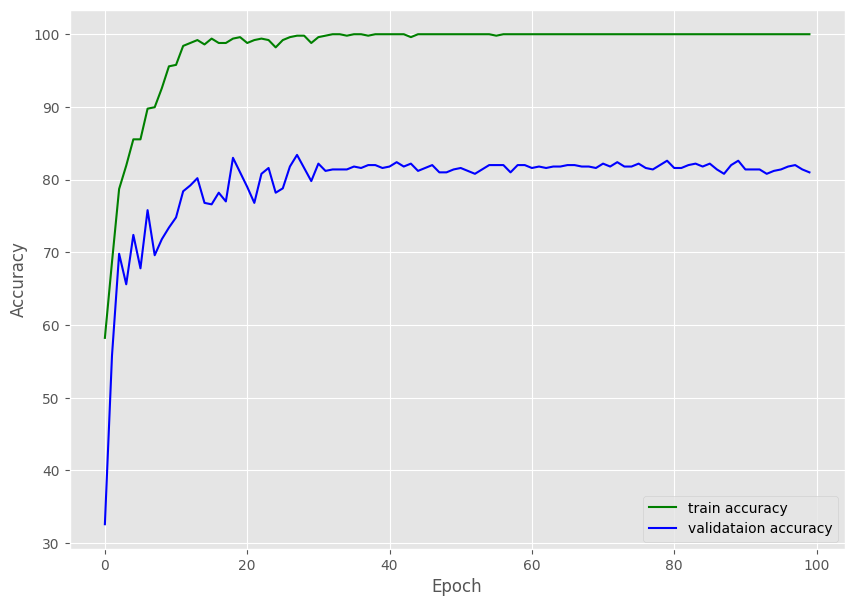

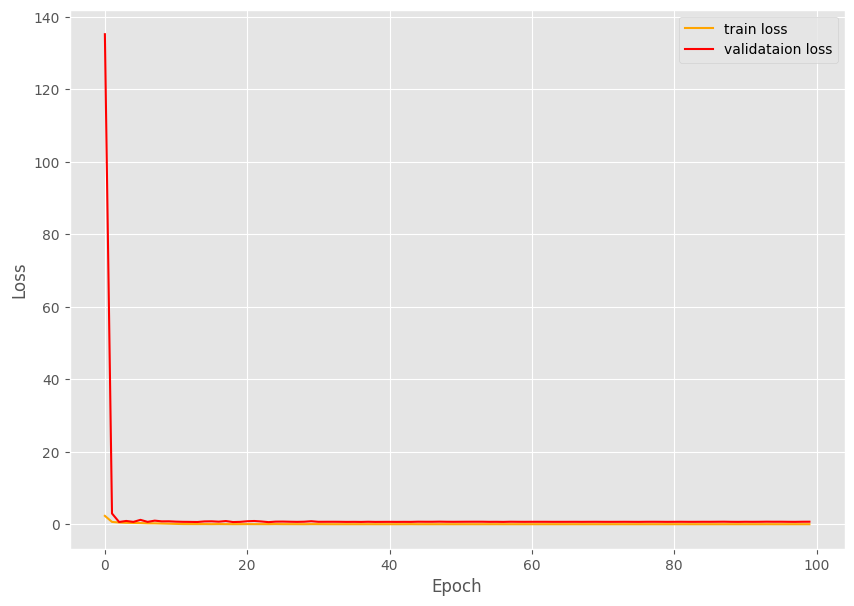

saving model...
training complete


In [13]:
#12 plotting
print('Saving loss and accuracy plots')
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'data/{acc_plot_name}.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'data/{loss_plot_name}.png')
plt.show()

print('saving model...')
torch.save(model.state_dict(), f'data/{model_name}.pt')
print('training complete')